# Taxi Orders Forecasting

## Table of Contents <a id='back'></a>

* [1. Introduction](#intro)
* [2. Initiation](#init)
* [3. Data Overview](#overview)
* [4. Data Preparation](#prep)
	* [4.1. Creating Stationary Series](#1)
	* [4.2. Handling Outliers](#2)
	* [4.3. Scoring function](#3)
	* [4.4. Features Engineering](#4)
	* [4.5. Define Features and Target](#5)
* [5. Model Training](#train)
	* [5.1. Dummy Models](#51)
	* [5.2. Regression Models](#52)
	* [5.3. Searching the Best Parameters for Regressors](#53)
* [6. Model Evaluation](#eval)
* [7. General Conclusion](#end)

## 1. Introduction <a id='intro'></a>

### 1.1. Project Description

The taxi company called Sweet Lift has collected historical data on taxi orders at the airport. In order to attract more drivers during peak hours, it is necessary to predict the number of taxi orders for the next hour.

### 1.2. Objective

Train a learning model with RMSE on test set below 48.

### 1.3. Data Description
The dataset only consists of 2 columns:
* datetime - date and time of the orders rounded to the nearest 10 minutes
* num_orders - number of orders per 10 minutes

### 1.4. Methodology

The steps taken in this research are:
1. Exploratory Data Analysis
2. Data Preparation
3. Model Training
4. Model Testing
5. Conclusion

[back to table of contents](#back)

## 2. Initiation <a id='init'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, make_scorer

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings

In [2]:
np.random.seed(0)

[back to table of contents](#back)

## 3. Data Overview <a id='overview'></a>

### 3.1. All Data

In [3]:
try:
    taxi = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    taxi = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
    
taxi.sort_index(inplace=True)
taxi.index.is_monotonic

True

In [4]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


The raw data provides number of orders per 10 minutes. We will combine it per hour by averaging.

In [6]:
taxi = taxi.resample('1H').sum()

In [7]:
taxi['rolling_mean'] = taxi['num_orders'].rolling(24).mean()
taxi['rolling_std'] = taxi['num_orders'].rolling(24).std()

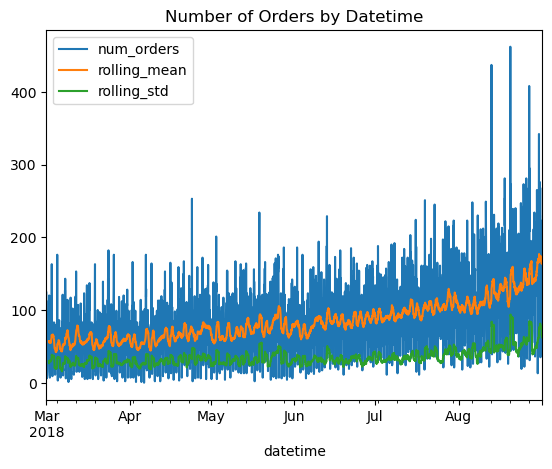

In [8]:
taxi.plot()
plt.title('Number of Orders by Datetime')
plt.show()

The mean and standard deviation is trending upward, therefore it is not suitable for forecasting.

Let's look the data closer.

### 3.2. 28 Days data

In [9]:
taxi_28 = taxi['2018-04-01':'2018-04-28']

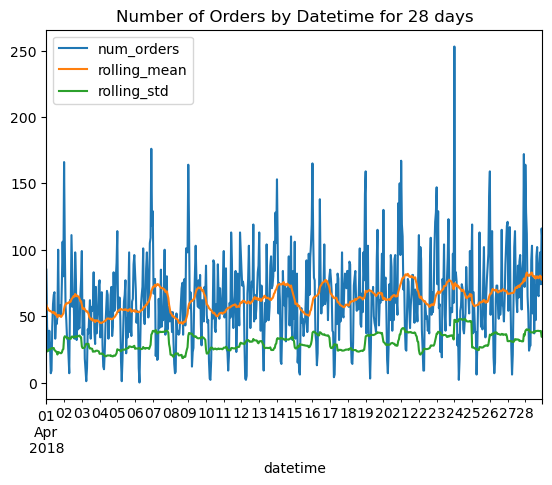

In [10]:
taxi_28.plot()
plt.title('Number of Orders by Datetime for 28 days')
plt.show()

In [11]:
decomposed = seasonal_decompose(taxi_28['num_orders'])

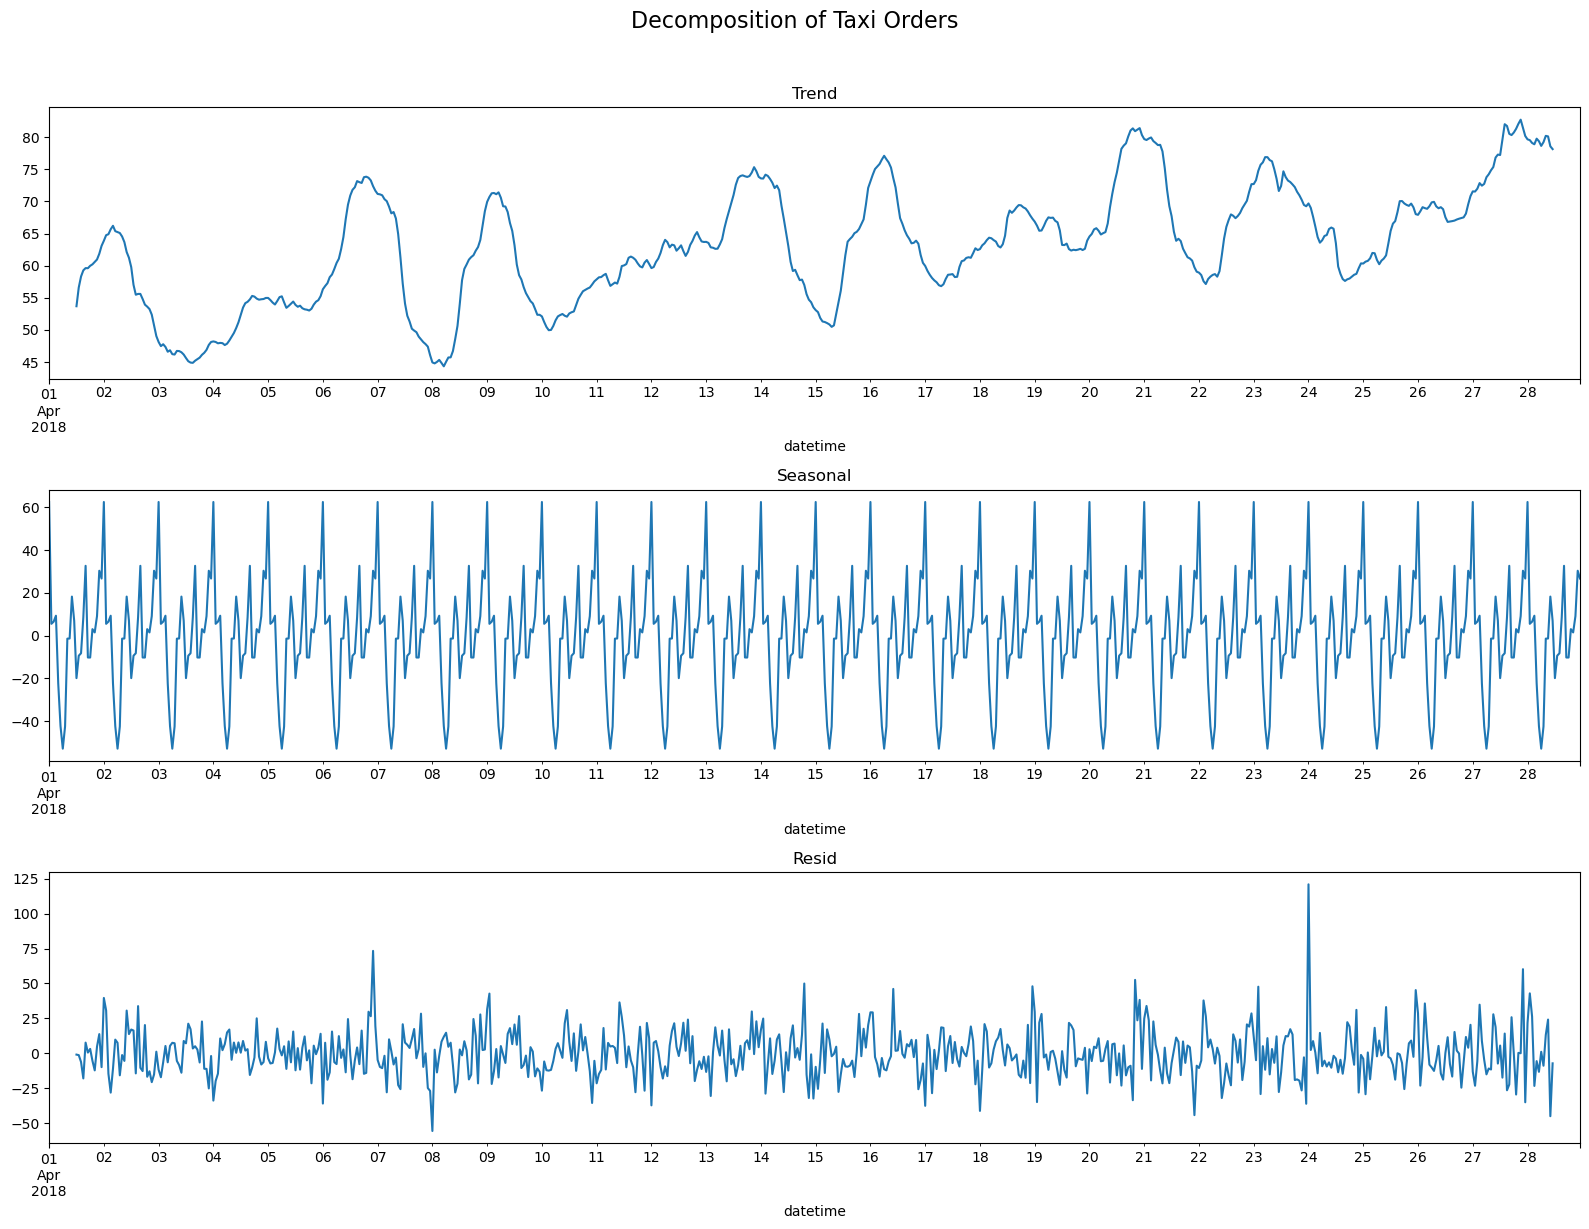

In [12]:
plt.figure(figsize=(16,12))
plt.suptitle('Decomposition of Taxi Orders', y=1.02, fontsize=16, fontweight=400)
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Resid')
plt.tight_layout()

There is a pattern in this series. The lowest demand is in Sundays followed by Tuesdays. The peak demand is in Saturdays followed by Mondays.

[back to table of contents](#back)

## 4. Data Preparation <a id='prep'></a>

### 4.1. Creating Stationary Series <a id='1'></a>

To get a reasonable prediction, we need a stationary pattern.

In [13]:
taxi_st = pd.DataFrame(taxi['num_orders'] - taxi['num_orders'].shift())
taxi_st.dropna(inplace=True)
taxi_st['rolling_mean'] = taxi_st['num_orders'].rolling(24).mean()
taxi_st['rolling_std'] = taxi_st['num_orders'].rolling(24).std()

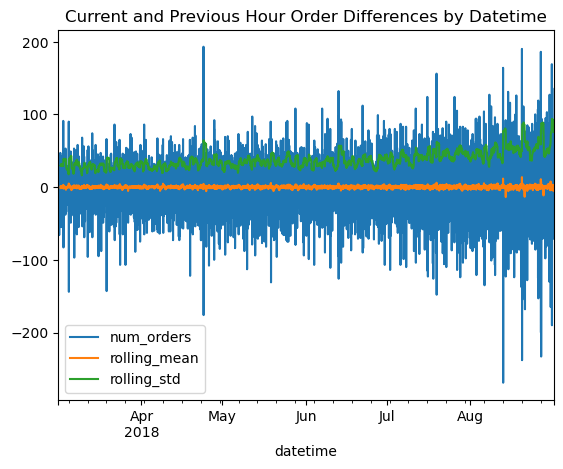

In [14]:
taxi_st.plot()
plt.title('Current and Previous Hour Order Differences by Datetime')
plt.show()

[back to table of contents](#back)

### 4.2. Handling Outliers <a id='2'></a>

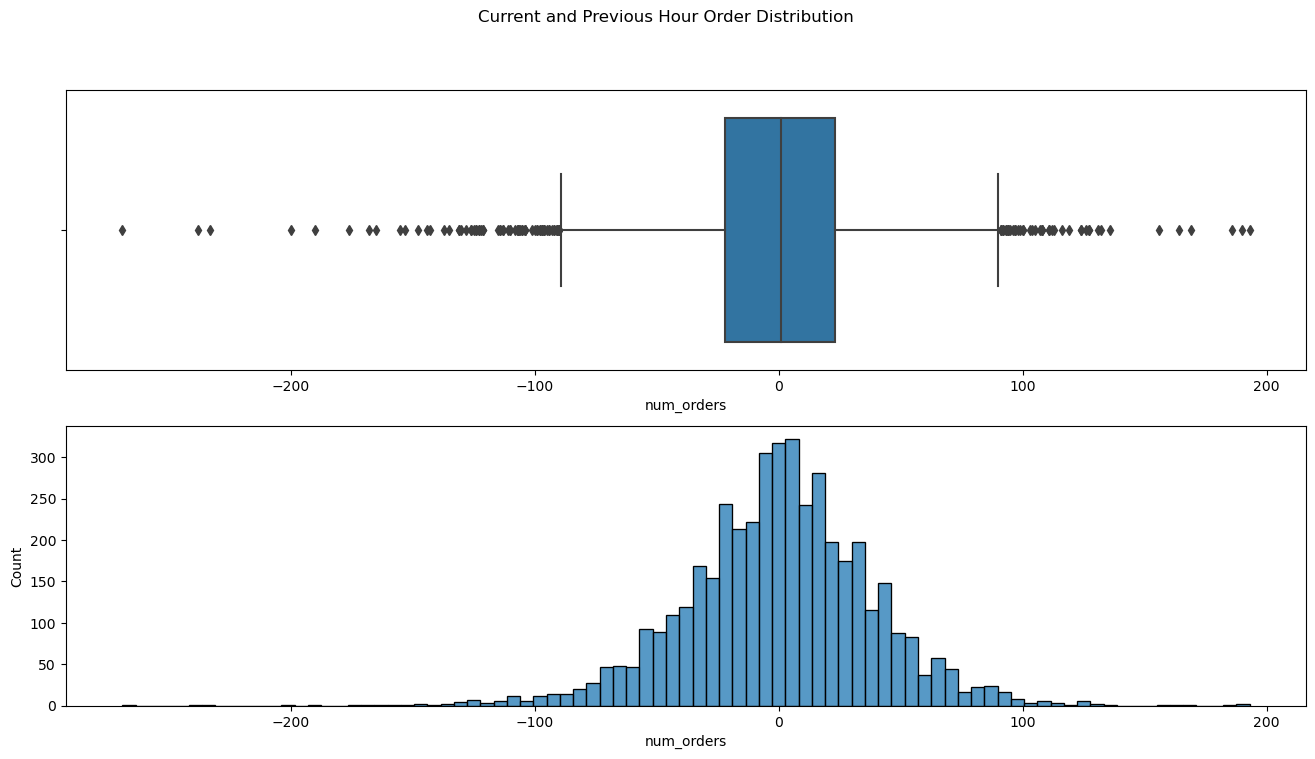

In [15]:
fig, ax = plt.subplots(2,1,figsize = (16,8))
sns.boxplot(data = taxi_st, x='num_orders', ax=ax[0])
sns.histplot(data = taxi_st, x='num_orders', ax=ax[1])
fig.suptitle('Current and Previous Hour Order Distribution')
plt.show()

We will remove outliers in the dataset.

In [16]:
iqr = st.iqr(taxi_st['num_orders'])
lower = taxi_st['num_orders'].quantile(0.25) - 1.5*iqr
upper = taxi_st['num_orders'].quantile(0.75) + 1.5*iqr
print(f'Lower bound = {lower} and upper bound = {upper}')

Lower bound = -89.5 and upper bound = 90.5


In [17]:
taxi_st = taxi_st.query("num_orders >= @lower and num_orders <= @upper")

In [18]:
taxi_st.describe()

,num_orders,rolling_mean,rolling_std
count,4292.000000,4269.000000,4269.000000
mean,0.889562,0.012191,37.639237
std,33.683136,1.371415,11.339436
min,-89.000000,-11.458333,16.118223
25%,-21.000000,-0.750000,29.914825
50%,1.000000,0.041667,35.802599
75%,23.000000,0.791667,42.491240
max,90.000000,7.625000,93.213134


In [19]:
taxi_st.shape

(4292, 3)

[back to table of contents](#back)

### 4.3. Scoring function <a id='3'></a>

In [20]:
def rmse(y_true,y_pred):
    return mean_squared_error(y_true,y_pred)**0.5

In [21]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [22]:
rmse_train = {}
rmse_test = {}

[back to table of contents](#back)

### 4.4. Features Engineering <a id='4'></a>

In [23]:
def make_features(data, max_lag, rolling_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for i in range(1,max_lag+1):
        data['lag_{}'.format(i)] = data['num_orders'].shift(i)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_size).mean()
    data['rolling_std'] = data['num_orders'].shift().rolling(rolling_size).std()

In [24]:
warnings.filterwarnings('ignore')
make_features(taxi_st, 3, 24)

In [25]:
taxi_st.dropna(inplace=True)

[back to table of contents](#back)

### 4.5. Define Features and Target <a id='5'></a>

In [26]:
train, test = train_test_split(taxi_st, shuffle=False, test_size=0.1)

In [27]:
features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

[back to table of contents](#back)

## 5. Model Training <a id='train'></a>

### 5.1. Dummy Models <a id='51'></a>

#### Constant Target Median Model:

In [28]:
print('Test set target mean=', target_test.median())

train_baseline = np.ones(target_train.shape) * target_train.median()
test_baseline = np.ones(target_test.shape) * target_train.median()

rmse_train['Median'] = rmse(target_train, train_baseline)
rmse_test['Median'] = rmse(target_test, test_baseline)

print('RMSE for train set =', rmse_train['Median'])
print('RMSE for test set =', rmse_test['Median'])

Test set target mean= 2.0
RMSE for train set = 32.49671443148441
RMSE for test set = 43.07120622435143


#### Previous Value Model:

In [29]:
pred_previous_train = target_train.shift(fill_value=0)
pred_previous_test = target_test.shift()
pred_previous_test.iloc[0] = target_train.iloc[-1]

rmse_train['Previous'] = rmse(target_train, pred_previous_train)
rmse_test['Previous'] = rmse(target_test, pred_previous_test)

print('RMSE for train set =', rmse_train['Previous'])
print('RMSE for test set =', rmse_test['Previous'])

RMSE for train set = 50.79248304904916
RMSE for test set = 64.13968582261599


[back to table of contents](#back)

### 5.2. Regression Models <a id='52'></a>

#### Make Pipelines

In [30]:
pipe_lr = Pipeline([('scaler', StandardScaler()),
                       ('LinearRegression', LinearRegression())])
pipe_dtr = Pipeline([('scaler', StandardScaler()),
                    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=0))])
pipe_rfr = Pipeline([('scaler', StandardScaler()),
                    ('RandomForestRegressor', RandomForestRegressor(random_state=0))])
pipe_cb = Pipeline([('scaler', StandardScaler()),
                       ('CatBoostRegressor', CatBoostRegressor(random_seed=0, verbose=False))])
pipe_lgb =  Pipeline([('scaler', StandardScaler()),
                       ('LGBMRegressor', LGBMRegressor(random_state=0))])
pipe_xgb = Pipeline([('scaler', StandardScaler()),
                       ('XGBRegressor', XGBRegressor(seed=0))])

pipelines = [pipe_lr, pipe_dtr, pipe_rfr, pipe_cb, pipe_lgb, pipe_xgb]

pipe_dict = {pipe_lr:'LinearRegression', pipe_dtr: 'DecisionTreeRegressor', pipe_rfr:'RandomForestRegressor',\
             pipe_cb: 'CatBoostRegressor', pipe_lgb: 'LGBMRegressor', pipe_xgb:'XGBRegressor'}

#### Test Pipeline

In [31]:
for pipe in pipelines:
    print(pipe_dict[pipe])
    print(cross_val_score(pipe, features_train, target_train, scoring=rmse_scorer, cv=5))
    print()

LinearRegression
[-26.23743582 -28.83571541 -31.58073775 -31.36635437 -37.65069904]

DecisionTreeRegressor
[-42.69337557 -40.04647365 -43.81700227 -44.21360026 -49.52294554]

RandomForestRegressor
[-26.97284489 -28.92495049 -30.94355728 -31.48036236 -38.36581709]

CatBoostRegressor
[-27.20552609 -28.96290977 -30.88575688 -31.40542171 -39.13626447]

LGBMRegressor
[-26.89981356 -28.84690787 -31.62124753 -32.0510474  -39.02030531]

XGBRegressor
[-28.33223823 -30.80929413 -32.84863991 -33.78849002 -41.2188591 ]



### 5.3. Searching the Best Parameters for Regressors <a id='53'></a>

#### Decision Tree Regressor

In [32]:
parameters = {'DecisionTreeRegressor__max_depth': list(np.arange(1,16,2))}

In [33]:
grid_dtr = GridSearchCV(pipe_dtr, param_grid=parameters, scoring=rmse_scorer, cv=5)
grid_dtr_fit = grid_dtr.fit(features_train, target_train)

In [34]:
print(grid_dtr_fit.best_estimator_)
print(grid_dtr_fit.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('DecisionTreeRegressor',
                 DecisionTreeRegressor(max_depth=3, random_state=0))])
-31.40080845594259


#### Random Forest Regressor

In [35]:
parameters = {'RandomForestRegressor__n_estimators': list(np.arange(1,31,5)), 'RandomForestRegressor__max_depth': list(np.arange(1,16,2))}

In [36]:
grid_rfr = GridSearchCV(pipe_rfr, param_grid=parameters, scoring=rmse_scorer, cv=5)
grid_rfr_fit = grid_rfr.fit(features_train, target_train)

In [37]:
print(grid_rfr_fit.best_estimator_)
print(grid_rfr_fit.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('RandomForestRegressor',
                 RandomForestRegressor(max_depth=5, n_estimators=26,
                                       random_state=0))])
-30.89342099343471


#### Cat Boost Regressor

In [38]:
parameters = {'CatBoostRegressor__learning_rate': [0.01,0.1,0.4], 'CatBoostRegressor__n_estimators': list(np.arange(1,31,5)), 'CatBoostRegressor__max_depth': list(np.arange(1,16,2))}

In [39]:
grid_cb = GridSearchCV(pipe_cb, param_grid=parameters, scoring=rmse_scorer, cv=5)
grid_cb_fit = grid_cb.fit(features_train, target_train)

In [40]:
print(grid_cb_fit.best_estimator_)
print(grid_cb_fit.best_params_)
print(grid_cb_fit.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('CatBoostRegressor',
                 <catboost.core.CatBoostRegressor object at 0x000001D2D76A36A0>)])
{'CatBoostRegressor__learning_rate': 0.1, 'CatBoostRegressor__max_depth': 7, 'CatBoostRegressor__n_estimators': 26}
-30.70033058016955


#### LightGBM Regressor

In [41]:
parameters = {'LGBMRegressor__learning_rate': [0.01,0.1,0.4], 'LGBMRegressor__n_estimators': list(np.arange(1,31,5)), 'LGBMRegressor__max_depth': list(np.arange(1,16,2))}

In [42]:
grid_lgb = GridSearchCV(pipe_lgb, param_grid=parameters, scoring=rmse_scorer, cv=5)
grid_lgb_fit = grid_lgb.fit(features_train, target_train)

In [43]:
print(grid_lgb_fit.best_estimator_)
print(grid_lgb_fit.best_params_)
print(grid_lgb_fit.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('LGBMRegressor',
                 LGBMRegressor(max_depth=3, n_estimators=26, random_state=0))])
{'LGBMRegressor__learning_rate': 0.1, 'LGBMRegressor__max_depth': 3, 'LGBMRegressor__n_estimators': 26}
-30.81597211698798


#### XGBoost Regressor

In [44]:
parameters = {'XGBRegressor__learning_rate': [0.01,0.1,0.4], 'XGBRegressor__n_estimators': list(np.arange(1,31,5)), 'XGBRegressor__max_depth': list(np.arange(1,16,2))}

In [45]:
grid_xgb = GridSearchCV(pipe_xgb, param_grid=parameters, scoring=rmse_scorer, cv=5)
grid_xgb_fit = grid_xgb.fit(features_train, target_train)

In [46]:
print(grid_xgb_fit.best_estimator_)
print(grid_xgb_fit.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('XGBRegressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=26,
                              n_jobs=None, nu

[back to table of contents](#back)

## 6. Model Evaluation <a id='eval'></a>

In [47]:
pipe_lr_m = Pipeline([('scaler', StandardScaler()),
                       ('LinearRegression', LinearRegression())])
pipe_dtr_m = Pipeline([('scaler', StandardScaler()),
                    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=0,max_depth=3))])
pipe_rfr_m = Pipeline([('scaler', StandardScaler()),
                    ('RandomForestRegressor', RandomForestRegressor(random_state=0,n_estimators=21,max_depth=5))])
pipe_cb_m = Pipeline([('scaler', StandardScaler()),
                       ('CatBoostRegressor', CatBoostRegressor(random_seed=0, verbose=False,learning_rate=0.4,n_estimators=26,max_depth=3))])
pipe_lgb_m =  Pipeline([('scaler', StandardScaler()),
                       ('LGBMRegressor', LGBMRegressor(random_state=0,learning_rate=0.1,n_estimators=26,max_depth=3))])
pipe_xgb_m = Pipeline([('scaler', StandardScaler()),
                       ('XGBRegressor', XGBRegressor(seed=0,learning_rate=0.1,n_estimators=26,max_depth=3))])

pipelines_m = [pipe_lr_m, pipe_dtr_m, pipe_rfr_m, pipe_cb_m, pipe_lgb_m, pipe_xgb_m]

pipe_dict_m = {pipe_lr_m:'LinearRegression', pipe_dtr_m: 'DecisionTreeRegressor', pipe_rfr_m:'RandomForestRegressor',\
             pipe_cb_m: 'CatBoostRegressor', pipe_lgb_m: 'LGBMRegressor', pipe_xgb_m:'XGBRegressor'}

In [48]:
def test_models(pipe):
    pipe.fit(features_train, target_train)
    pred_train = pipe.predict(features_train)
    pred_test = pipe.predict(features_test)

    rmse_train['{}'.format(pipe_dict_m[pipe])] = rmse(target_train, pred_train)
    rmse_test['{}'.format(pipe_dict_m[pipe])] = rmse(target_test, pred_test)

In [49]:
for pipe in pipelines_m:
    test_models(pipe)

In [50]:
rmse_all = pd.DataFrame([rmse_train, rmse_test], index=['rmse_train', 'rmse_test']).T.reset_index().melt(id_vars='index')

In [51]:
rmse_all_wide = rmse_all.pivot(index='index',values='value',columns='variable').sort_values(by='rmse_test')
rmse_all_wide

variable,rmse_test,rmse_train
index,,
XGBRegressor,42.586754,30.040301
LinearRegression,42.626416,31.203094
LGBMRegressor,42.859487,30.078108
Median,43.071206,32.496714
RandomForestRegressor,43.082329,29.432543
CatBoostRegressor,43.120162,29.950108
DecisionTreeRegressor,43.693366,30.994771
Previous,64.139686,50.792483


In [52]:
rmse_all_wide[rmse_all_wide.index != 'Previous'].describe()

variable,rmse_test,rmse_train
count,7.000000,7.000000
mean,43.005674,30.599377
std,0.373475,1.039875
min,42.586754,29.432543
25%,42.742951,29.995204
50%,43.071206,30.078108
75%,43.101246,31.098932
max,43.693366,32.496714


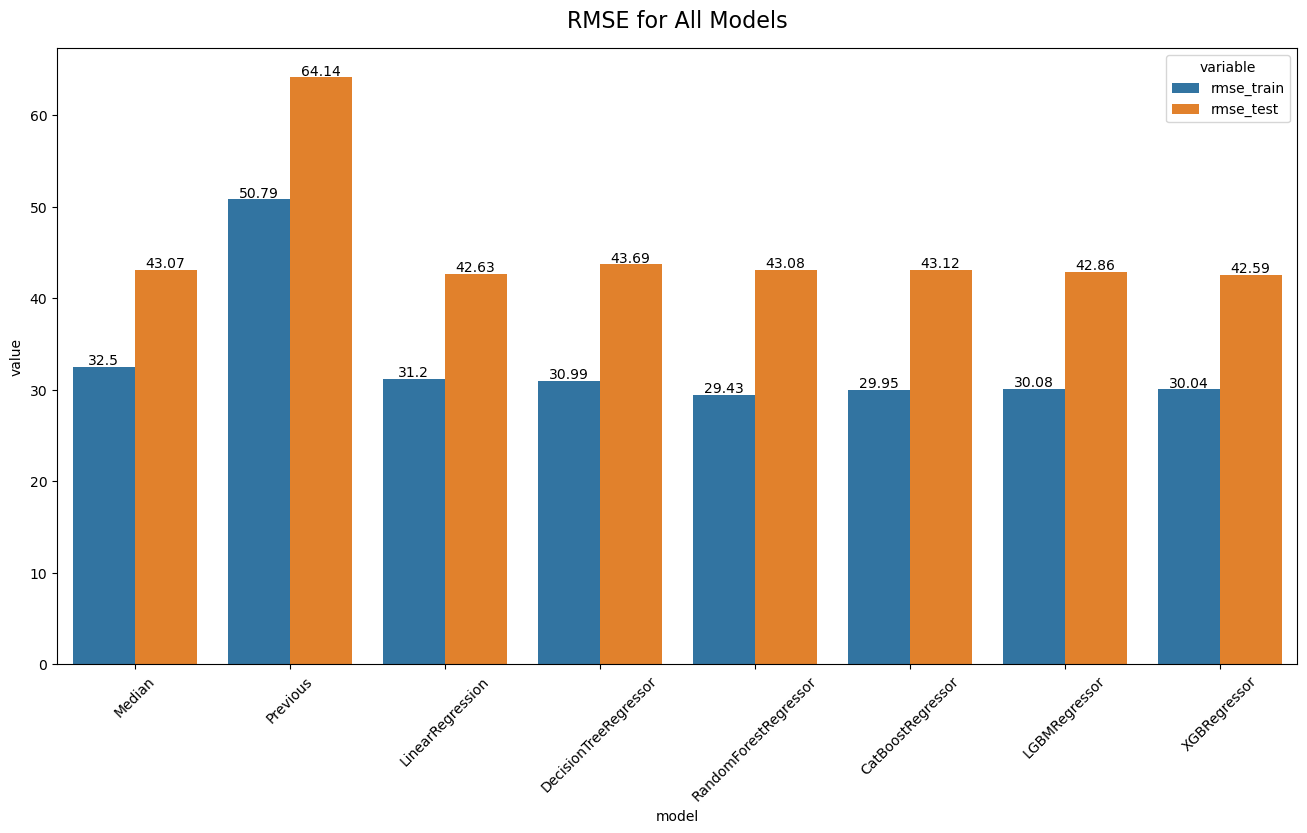

In [53]:
plt.figure(figsize=(16,8))
a = sns.barplot(data=rmse_all, x='index', y='value', hue='variable')

for i in range(len(rmse_all)//2):
    a.text(i-0.20, rmse_all.loc[i,'value']+0.25, str(round(rmse_all.loc[i,'value'],2)), horizontalalignment='center')
    
for i in range(len(rmse_all)//2, len(rmse_all)):
    a.text(i-len(rmse_all)//2+0.20, rmse_all.loc[i,'value']+0.25, str(round(rmse_all.loc[i,'value'],2)), horizontalalignment='center')
    
plt.title('RMSE for All Models', fontsize=16, fontweight=400, y=1.02)
plt.xticks(rotation=45)
plt.xlabel('model')
plt.show()

Surprisingly, linear regression is performs the best with RMSE of 42.7 orders, this number is still large remembering the min difference is 89 orders, and max difference is 90 orders.

[back to table of contents](#back)

## 7. General Conclusion <a id='end'></a>

First, we check whether there is any pattern in the dataset by decomposing it. We can see that there is a trend and seasonality in the dataset. The lowest demand is in Sundays followed by Tuesdays. On the other hand, the peak demand is in Saturdays followed by Mondays. The response variable is then transformed into difference between current and previous value so that we get a stationary time-series that is suitable for forecasting. By plotting in boxplot, we see that there are outliers below 89.5 and above 90.5. Therefore, we remove those values in advance. After that, we create features for the forecasting which includes day, month, year, weekday, lagging values, rolling mean and rolling standard deviation. And then we split the data into training and testing set.

We create models using test set median, previous values, linear regression, decision tree regressor, random forest regressor, Cat Boost Regressor, LightGBM Regressor, and XGBoost Regressor. Using the best hyperparameters from Grid Search based on RMSE as scorer, we then forecast the training and testing set. We get that the **best model is XGBRegressor model with RMSE of 42.58 orders on testing set.** Predictions by other models are only slightly worse by 0.06 – 1.08 orders on testing set and 1.3 - 1.8 orders on training set except model with previous values. This difference in orders is still large remembering the min. difference is 89 orders and max. difference is 90 orders.

[back to table of contents](#back)